In [2]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
getwd()

[1] "/mnt/hdd/develop/kaggle/R_sources/house_prices"

In [4]:
source('main.R')
house_prices$helpers$import_libs()

combined_dataset <-
    # load data
    house_prices$helpers$load_data() %>%
    # remove outliers
    (house_prices$outliers$remove_outliers) %>%
    # fix NA values
    (house_prices$missing$categ$replace_with_most_common) %>%
    (house_prices$missing$categ$fix_valid) %>%
    (house_prices$missing$numeric$replace_with_zero) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice, -Id)

#####################
# transform numeric #
#####################

transformation_config <- house_prices$trans$numeric$get_transformation_config(combined_dataset)

transformation_config

combined_dataset <-
    house_prices$trans$numeric$apply_transform(combined_dataset, transformation_config)


dataset <- 
    combined_dataset %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

dataset %>% nrow
dataset %>% head

var,predictor,score
BsmtUnfSF,sqrt,79.97603
GrLivArea,log,91.15794
LotArea,log,73.38993
TotRmsAbvGrd,log,30.68502
X1stFlrSF,log,90.77166


[1] 1458

MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,price_log
60,RL,65,9.042040,Pave,_none_,Reg,Lvl,AllPub,Inside,⋯,0,_none_,_none_,_none_,0,2,2008,WD,Normal,12.24769
20,RL,80,9.169623,Pave,_none_,Reg,Lvl,AllPub,FR2,⋯,0,_none_,_none_,_none_,0,5,2007,WD,Normal,12.10901
60,RL,68,9.328212,Pave,_none_,IR1,Lvl,AllPub,Inside,⋯,0,_none_,_none_,_none_,0,9,2008,WD,Normal,12.31717
70,RL,60,9.164401,Pave,_none_,IR1,Lvl,AllPub,Corner,⋯,0,_none_,_none_,_none_,0,2,2006,WD,Abnorml,11.84940
60,RL,84,9.565284,Pave,_none_,IR1,Lvl,AllPub,FR2,⋯,0,_none_,_none_,_none_,0,12,2008,WD,Normal,12.42922
50,RL,85,9.555064,Pave,_none_,IR1,Lvl,AllPub,Inside,⋯,0,_none_,MnPrv,Shed,700,10,2009,WD,Normal,11.87060


In [5]:
L2Loss = function (vec) {
    sum(vec**2) / length(vec)
}

In [17]:
formulas_for_validation = data_frame(
    
    formula = c(
        'price_log ~ GrLivArea',
        'price_log ~ GrLivArea + OverallQual',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir + LotArea',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir + LotArea + KitchenQual'
    )
)
formulas_for_validation

formula
price_log ~ GrLivArea
price_log ~ GrLivArea + OverallQual
price_log ~ GrLivArea + OverallQual + BsmtFinSF1
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir + LotArea


In [7]:
iterate <- function(sample_index) {
    
    test_y <- dataset[-sample_index, 'price_log'][[1]]

    totalset <- 
        dataset %>% 
        mutate(price_log = replace(price_log, -sample_index, NA))

    totalset <-
        house_prices$trans$categ$rating_transform(totalset, price_log)

    trainset <- totalset[sample_index,]
    testset <- totalset[-sample_index,]

    formulas_for_validation %>%
    mutate(
        model = map(formula, ~lm(as.formula(.), data=trainset)),

        r2 = map_dbl(model, function (mod) {
            summary(mod)$r.squared
        }),

        L2_train = map_dbl(model, function (mod) {
            augment <- broom::augment(mod)
            L2Loss(augment[['price_log']] - augment$.fitted)
        }),

        L2_test = map_dbl(model, function (mod) {
            test_predicted <- predict(mod, testset)
            L2Loss(test_predicted - test_y)
        })
    ) %>%
    select(-model)
}

In [18]:
caret::createDataPartition(
    y = dataset[['price_log']], 
    p = 0.5, 
    list = T, 
    times = 20
) %>%
map(iterate) -> x

In [19]:
y <- bind_rows(x, .id='sample')

y %>%
group_by(formula) %>%
summarise(
    r2 = mean(r2),
    L2_train = mean(L2_train),
    L2_test = mean(L2_test)
)

formula,r2,L2_train,L2_test
price_log ~ GrLivArea,0.5463052,0.07299385,0.07284464
price_log ~ GrLivArea + OverallQual,0.7694302,0.03709715,0.03832563
price_log ~ GrLivArea + OverallQual + BsmtFinSF1,0.8149390,0.02977547,0.03060293
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood,0.8521370,0.02379609,0.02458125
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea,0.8635241,0.02196045,0.02267066
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond,0.8776053,0.01969702,0.02087823
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF,0.8877649,0.01806257,0.01918180
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition,0.8936652,0.01711232,0.01832656
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir,0.8983201,0.01636482,0.01748751
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir + LotArea,0.9022092,0.01574049,0.01687585


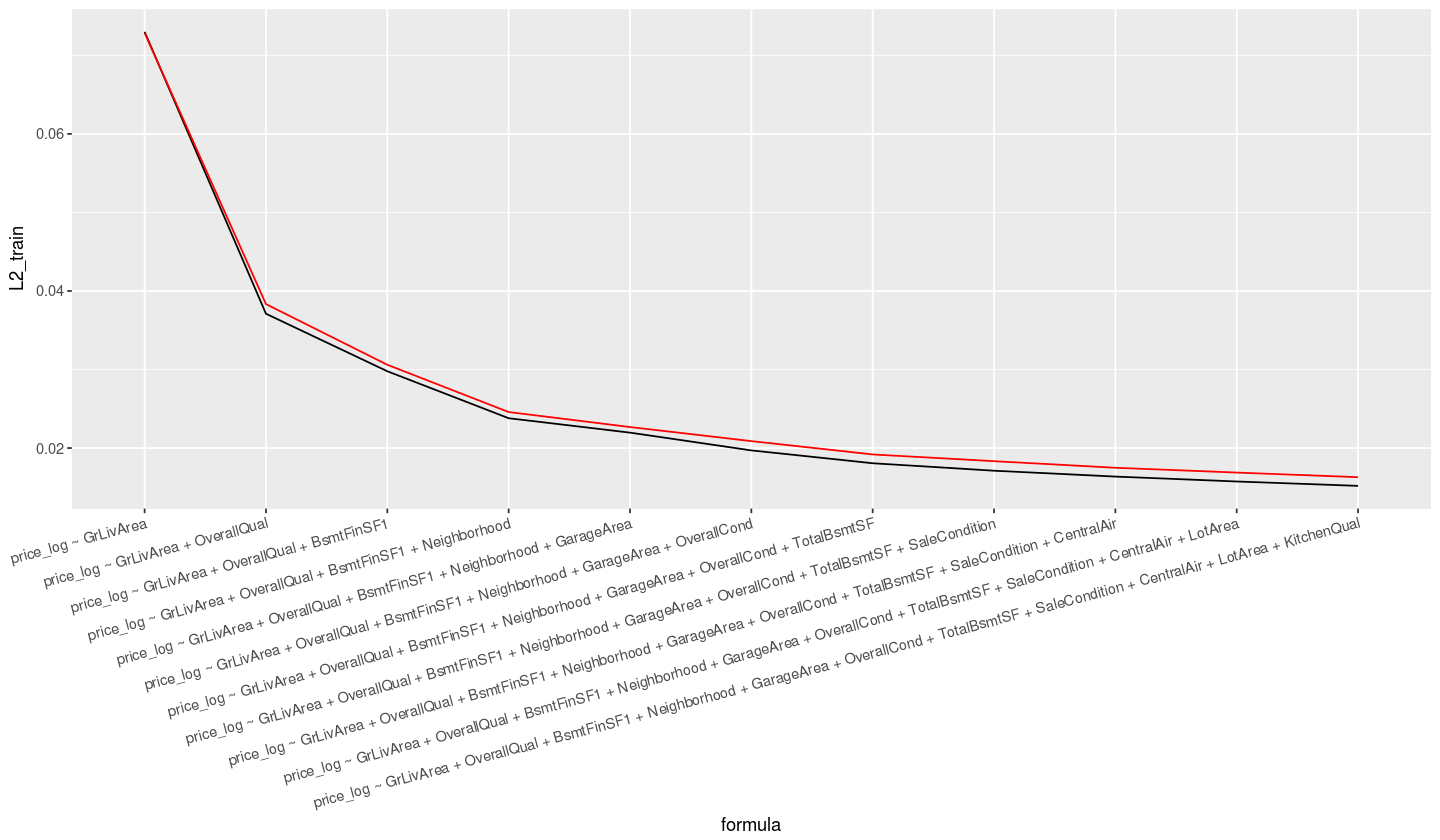

In [20]:
options(repr.plot.width = 12, repr.plot.height = 7)

y %>%
group_by(formula) %>%
summarise(
    L2_train = mean(L2_train),
    L2_test = mean(L2_test)
) %>% 
ggplot() +
geom_line(aes(x=formula, y=L2_train, group=1)) +
geom_line(aes(x=formula, y=L2_test, group=1), color='red') +
theme(axis.text.x = element_text(angle = 15, hjust = 1))

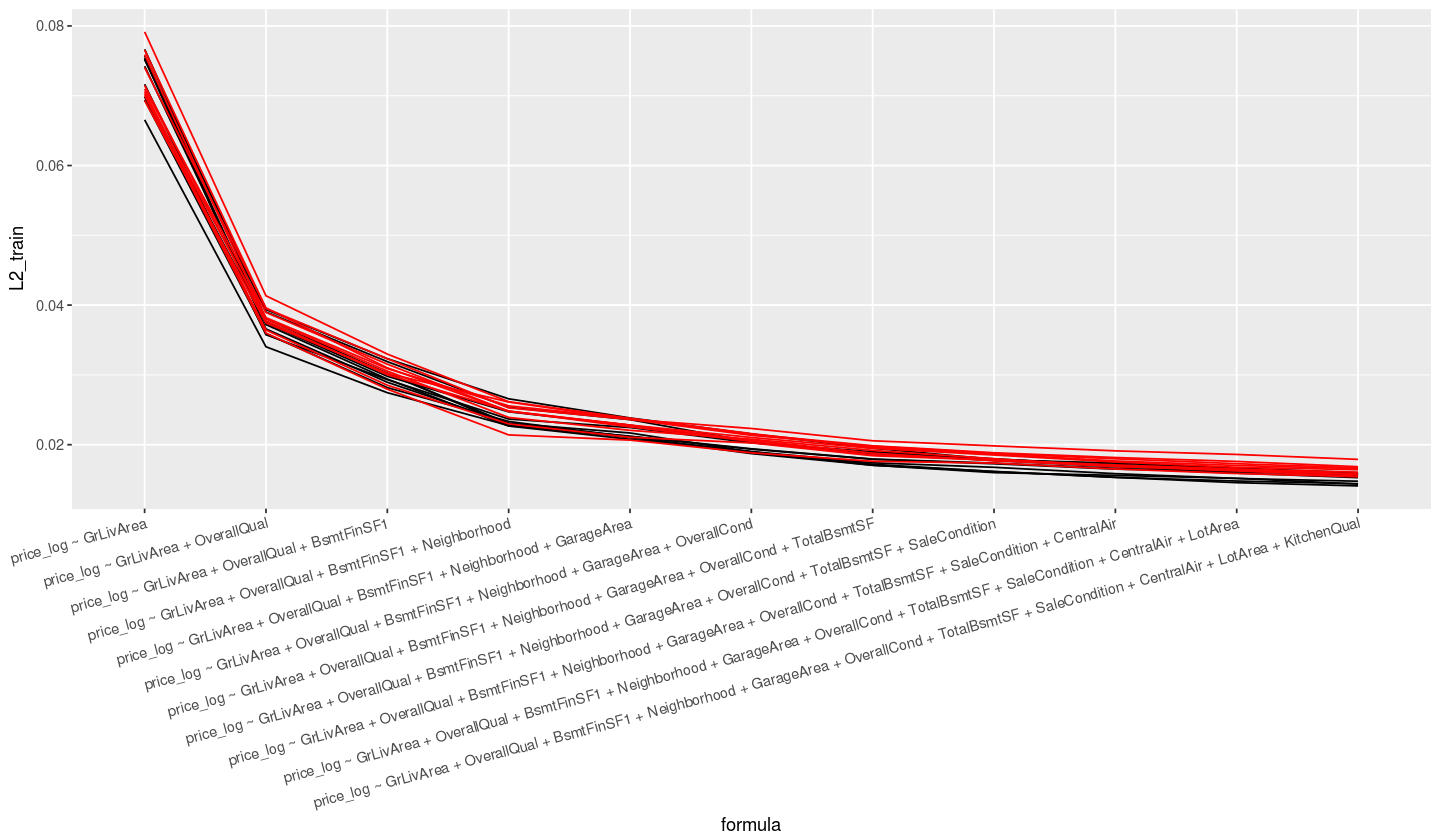

In [21]:
options(repr.plot.width = 12, repr.plot.height = 7)

y %>% 
ggplot() +
geom_line(aes(x=formula, y=L2_train, group=sample)) +
geom_line(aes(x=formula, y=L2_test, group=sample), color='red') +
theme(axis.text.x = element_text(angle = 15, hjust = 1))